In [2]:
import numpy as np
from skimage import io, color
from skimage.transform import resize
from keras.applications.inception_resnet_v2 import preprocess_input, InceptionResNetV2
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Input, Conv2D, RepeatVector, Reshape, concatenate, UpSampling2D
from keras.models import Model
from keras.callbacks import ModelCheckpoint 
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.io import imsave,imshow
import PIL
import os
from PIL import Image
import tensorflow as tf
from skimage.io import imsave
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

Using TensorFlow backend.


In [3]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [19]:
!mkdir train
!mkdir test

In [20]:
cd train

/content/train


In [21]:
!wget - O https://storage.googleapis.com/open-images-extended/extended-crowdsourced-images-0.tar.gz

--2020-08-02 20:09:53--  http://-/
Resolving - (-)... failed: Name or service not known.
wget: unable to resolve host address ‘-’
--2020-08-02 20:09:53--  http://o/
Resolving o (o)... failed: Name or service not known.
wget: unable to resolve host address ‘o’
--2020-08-02 20:09:53--  https://storage.googleapis.com/open-images-extended/extended-crowdsourced-images-0.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9170458279 (8.5G) [application/gzip]
Saving to: ‘extended-crowdsourced-images-0.tar.gz’

extended-crowdsourc 100%[===================>]   8.54G  43.7MB/s    in 3m 20s  

2020-08-02 20:13:13 (43.8 MB/s) - ‘extended-crowdsourced-images-0.tar.gz’ saved [9170458279/9170458279]

FINISHED --2020-08-02 20:13:13--
Total wall clock time: 3m 20s
Downloaded: 1 files, 8.5G

In [27]:
batch_size = 8
train_images_path = 'train'
test_images_path = 'test'
colorizer_input = (256, 256)
inception_input_size = (299, 299)
epochs = 50
steps_per_epoch = 50

In [23]:
!tar -zxvf extended-crowdsourced-images-0.tar.gz

Streaming output truncated to the last 5000 lines.
crowdsource_images-00000-of-00010/fede73a11e4ab4a9.jpg
crowdsource_images-00000-of-00010/14a212226e8e9031.jpg
crowdsource_images-00000-of-00010/67c60000aad0c209.jpg
crowdsource_images-00000-of-00010/e54fc3189385db06.jpg
crowdsource_images-00000-of-00010/969a6915b0530d3c.jpg
crowdsource_images-00000-of-00010/af585eb50a092fda.jpg
crowdsource_images-00000-of-00010/ef3a0d6aa49da193.jpg
crowdsource_images-00000-of-00010/2ed6457782a59db4.jpg
crowdsource_images-00000-of-00010/f0624eaa0139cbfe.jpg
crowdsource_images-00000-of-00010/dd1c88f52da77247.jpg
crowdsource_images-00000-of-00010/9422295247e34016.jpg
crowdsource_images-00000-of-00010/28658c7c017b3a3d.jpg
crowdsource_images-00000-of-00010/33ee2a0972b43d7f.jpg
crowdsource_images-00000-of-00010/66ab5e66b64cc0f6.jpg
crowdsource_images-00000-of-00010/288ad63a6250a279.jpg
crowdsource_images-00000-of-00010/6989c9f9ab9d7689.jpg
crowdsource_images-00000-of-00010/3ca30c9339adbde0.jpg
crowdsource_im

In [25]:
len(os.listdir('crowdsource_images-00000-of-00010'))

45947

In [26]:
cd ..

/content


In [28]:
#Load weights
inception_model = InceptionResNetV2(weights='imagenet', include_top=True)

In [29]:
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

In [30]:
embed_input = Input(shape=(1000,))

# encoder
encoder_input = Input(shape=(256, 256, 1))
encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(encoder_input)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)

# fusion between our model and inception
fusion_output = RepeatVector(32 * 32)(embed_input) 
fusion_output = Reshape(([32, 32, 1000]))(fusion_output)
fusion_output = concatenate([encoder_output, fusion_output], axis=3) 
fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output) 

# decoder
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)

model = Model(inputs=[encoder_input, embed_input], outputs=decoder_output)

In [31]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_421 (Conv2D)             (None, 128, 128, 64) 640         input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_422 (Conv2D)             (None, 128, 128, 128 73856       conv2d_421[0][0]                 
__________________________________________________________________________________________________
conv2d_423 (Conv2D)             (None, 64, 64, 128)  147584      conv2d_422[0][0]                 
____________________________________________________________________________________________

In [32]:
#Create embedding
def create_resnet_embedding(grayscaled_rgb):
    resized_grayscaled_rgb = []
    for i in grayscaled_rgb:
        if i.shape[0] != 299 and i.shape[1] != 299:
            resized_grayscaled_rgb.append(resize(i, (299, 299, 3), mode='constant'))
        else:
            resized_grayscaled_rgb.append(i)
    resized_grayscaled_rgb = np.array(resized_grayscaled_rgb)
    resized_grayscaled_rgb = preprocess_input(resized_grayscaled_rgb)
    
    return inception_model.predict(resized_grayscaled_rgb)

In [33]:
def image_gen_train():
    test = True
    for batch in datagen.flow_from_directory(
        train_images_path,
        target_size=inception_input_size,
        color_mode='rgb',
        batch_size=batch_size,
        class_mode=None):
        
        # scale batch 
        batch = 1.0/255*batch

        # get image grayscale with 3 channels
        grayscaled_rgb = gray2rgb(rgb2gray(batch))
        
        batch_lab = []
        for img in batch:
            batch_lab.append(resize(img, (256, 256, 3), mode='constant'))
        batch_lab = np.array(batch_lab)
        batch_lab = rgb2lab(batch_lab)
        
        # b/w channel
        batch_l = batch_lab[:,:,:,0]
        batch_l = batch_l.reshape(batch_l.shape+(1,))
        
        batch_ab = batch_lab[:,:,:,1:] / 128
        yield ([batch_l, create_resnet_embedding(grayscaled_rgb)], batch_ab)

In [34]:
checkpoint_path = "output/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [37]:
# tensorboard = TensorBoard(log_dir="/output")
model.compile(optimizer='adam', loss='mse')
model.fit_generator(image_gen_train(), 
                    epochs=10, 
                    steps_per_epoch=steps_per_epoch, 
                    workers=0)
# model.fit_generator(image_gen_train(), 
#                     epochs=10, 
#                     callbacks=[cp_callback], 
#                     steps_per_epoch=steps_per_epoch, 
#                     workers=0)

Epoch 1/10
Found 45947 images belonging to 1 classes.
50/50 [==============================] - 41s 820ms/step - loss: 0.0095
Epoch 2/10
50/50 [==============================] - 40s 802ms/step - loss: 0.0107
Epoch 3/10
50/50 [==============================] - 40s 792ms/step - loss: 0.0113
Epoch 4/10
50/50 [==============================] - 40s 793ms/step - loss: 0.0110
Epoch 5/10
50/50 [==============================] - 39s 788ms/step - loss: 0.0089
Epoch 6/10
50/50 [==============================] - 40s 790ms/step - loss: 0.0102
Epoch 7/10
50/50 [==============================] - 40s 791ms/step - loss: 0.0099
Epoch 8/10
50/50 [==============================] - 40s 796ms/step - loss: 0.0101
Epoch 9/10
50/50 [==============================] - 40s 795ms/step - loss: 0.0094
Epoch 10/10
50/50 [==============================] - 40s 796ms/step - loss: 0.0090


In [38]:
# Save model
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("color_tensorflow_real_mode_v2.h5")

In [14]:
!mkdir data

In [39]:
test_images_path = "data"

In [43]:
imgs = []
inception_imgs = []
colorization_imgs = []
for f in os.listdir(test_images_path):
    print(f)
    img = load_img(os.path.join(test_images_path,f))
    imgs.append(img_to_array(img))
imgs = np.asarray(imgs)
imgs = 1.0/255*imgs
for img in imgs:
    inception_imgs.append(resize(img, (299, 299, 3), mode='constant'))
    colorization_imgs.append(resize(img, (256, 256, 3), mode='constant'))

inception_imgs = np.array(inception_imgs)
inception_imgs = gray2rgb(rgb2gray(inception_imgs))
embed = create_resnet_embedding(inception_imgs)

colorization_imgs = np.array(colorization_imgs)
X_batch = rgb2lab(colorization_imgs)[:,:,:,0] 
X_batch = X_batch.reshape(X_batch.shape+(1,))

pexels-pixabay-157661.jpg


In [44]:
X_batch.shape

(1, 256, 256, 1)

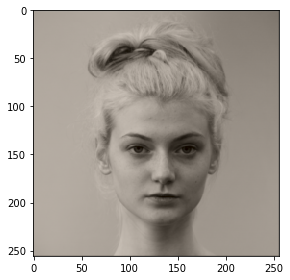

In [45]:
from skimage import img_as_ubyte

output = model.predict([X_batch, embed])
output = output * 128



idx = 0
# Output colorizations
for i in range(len(output)):
    cur = np.zeros((256, 256, 3))
    cur[:,:,0] = X_batch[i,:,:,0] 
    cur[:,:,1:] = output[i]
    if i == idx:
        imshow(lab2rgb(cur))
    #imsave("output/" + str(epochs) + "img_" + str(i) + '_' + str(steps_per_epoch) + ".png", lab2rgb(cur))